File already exists.


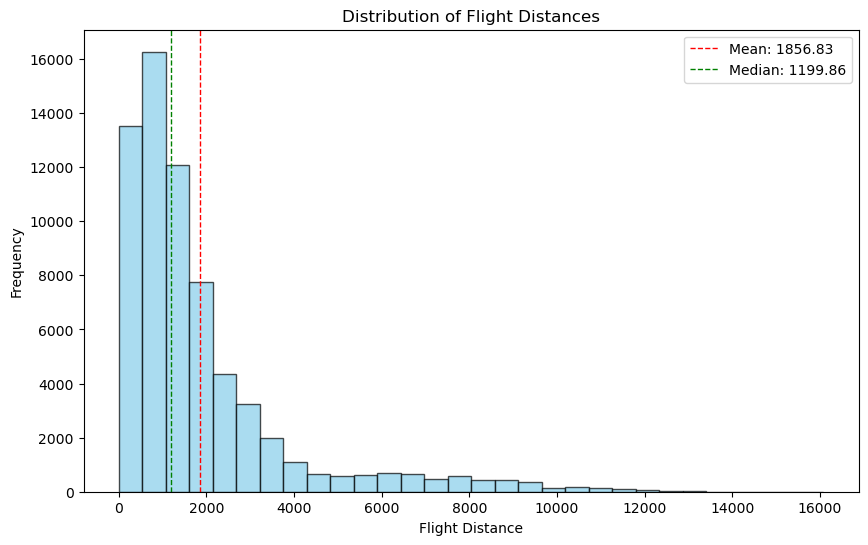

In [3]:
import os
import requests
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import radians
from math import sin
from math import cos
from math import atan2
from math import sqrt


class FIIU:
    
    def __init__(self, zip_url='https://gitlab.com/adpro9641208/group_03/-/raw/main/flight_data.zip'):
        """
        Downloads, extracts, and processes flight data from the given zip URL.
        Parameters:
        - zip_url (str): The URL of the flight data zip file.
        """
        # Set the destination folder for the extracted data in the main directory
        self.destination_folder = 'downloads'
        # Ensure the destination folder exists
        os.makedirs(self.destination_folder, exist_ok=True)
        # Define the path to the downloaded zip file
        zip_file_path = os.path.join(self.destination_folder, 'flight_data.zip')
        # Check if the zip file already exists
        if not os.path.exists(zip_file_path):
            # Download the zip file from the given URL
            response = requests.get(zip_url)
            # Save the zip file in the destination folder
            with open(zip_file_path, 'wb') as zip_file:
                zip_file.write(response.content)
            print("File downloaded successfully.")
        else:
            print("File already exists.")
        # Process the downloaded zip file
        zip_file = ZipFile(zip_file_path)
        zip_file.extractall(self.destination_folder)
        # Assign values to the instance attributes
        self.airlines_df = pd.read_csv(os.path.join(self.destination_folder, 'airlines.csv'))
        self.airplanes_df = pd.read_csv(os.path.join(self.destination_folder, 'airplanes.csv'))
        self.airports_df = pd.read_csv(os.path.join(self.destination_folder, 'airports.csv'))
        self.routes_df = pd.read_csv(os.path.join(self.destination_folder, 'routes.csv'))
        
        # Removing Superfluous Columns
        self.airports_df = self.airports_df.drop(['index', 'Timezone', 'Altitude', 'DST', 'Tz database time zone', 'Type', 'Source'], axis=1)
        self.routes_df = self.routes_df.drop(['index', 'Codeshare', 'Stops'], axis=1)
        
        # Cleaning and Type Casting
        self.airports_df = self.airports_df.dropna()
        self.routes_df = self.routes_df.dropna()
        self.airplanes_df = self.airplanes_df.dropna()
        self.airplanes_df = self.airplanes_df[self.airplanes_df['IATA code'] != '\\N']
        self.routes_df = self.routes_df[self.routes_df['Source airport ID'] != '\\N']
        self.routes_df['Source airport ID'] = self.routes_df['Source airport ID'].astype(int)
        self.routes_df['Model'] = self.routes_df['Equipment'].str.split('-')
        self.routes_df = self.routes_df.explode('Model')
        self.routes_df['Source airport ID'] = pd.to_numeric(self.routes_df['Source airport ID'].replace('\\N', np.nan), errors='coerce')
        self.routes_df['Destination airport ID'] = pd.to_numeric(self.routes_df['Destination airport ID'].replace('\\N', np.nan), errors='coerce')
        self.airports_df['Airport ID'] = pd.to_numeric(self.airports_df['Airport ID'].replace('\\N', np.nan), errors='coerce')


        self.distances = {}

    def _calculate_distances(self):
        distances = {}

        for index, row in self.routes_df.iterrows():
            source_airport_id = row['Source airport ID']
            dest_airport_id = row['Destination airport ID']

            source_coords = self.get_coordinates(source_airport_id)
            dest_coords = self.get_coordinates(dest_airport_id)

            if source_coords is not None and dest_coords is not None:
                distance = self.haversine_distance(*source_coords, *dest_coords)
                distances[(source_airport_id, dest_airport_id)] = distance

        return distances


    def haversine_distance(self, lat1, lon1, lat2, lon2):
        if None in [lat1, lon1, lat2, lon2]:
            return 0  # Return a default distance in case of None values

        R = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        return distance

    def get_coordinates(self, airport_id):
        row = self.airports_df[self.airports_df['Airport ID'] == airport_id]
        if not row.empty:
            latitude = row['Latitude'].values[0]
            longitude = row['Longitude'].values[0]
            return latitude, longitude
        else:
            return None, None


    def add_distance_column(self):

        # Convert the ID columns to the same data type if they are not already


    # Now perform the merge operation
    # ... rest of your method ...

    # Merge routes_df with airports_df to get source airport coordinates
        routes_with_source_coords = self.routes_df.merge(
            self.airports_df[['Airport ID', 'Latitude', 'Longitude']],
            left_on='Source airport ID',
            right_on='Airport ID',
            how='left'
        ).rename(columns={'Latitude': 'Source Latitude', 'Longitude': 'Source Longitude'})

    # Merge routes_with_source_coords with airports_df to get destination airport coordinates
        routes_with_all_coords = routes_with_source_coords.merge(
            self.airports_df[['Airport ID', 'Latitude', 'Longitude']],
            left_on='Destination airport ID',
            right_on='Airport ID',
            how='left'
        ).rename(columns={'Latitude': 'Destination Latitude', 'Longitude': 'Destination Longitude'})

    # Calculate distances and add as a new column
        self.routes_df['distance'] = routes_with_all_coords.apply(
            lambda row: self.haversine_distance(
                row['Source Latitude'], row['Source Longitude'],
                row['Destination Latitude'], row['Destination Longitude']
            ),
            axis=1
        )


    def distance_analysis(self, bins=30, show_mean=True, show_median=True):

        # Filter out None values (if any)
        valid_distances = self.routes_df['distance'].dropna()

        # Create a histogram of flight distances
        plt.figure(figsize=(10, 6))
        plt.hist(valid_distances, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)

        # Add vertical lines for mean and median distances
        if show_mean:
            mean_val = valid_distances.mean()
            plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
        if show_median:
            median_val = valid_distances.median()
            plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')

        # Set labels and title
        plt.xlabel('Flight Distance')
        plt.ylabel('Frequency')
        plt.title('Distribution of Flight Distances')

        # Show plot
        plt.legend()
        plt.show()

# URL for the raw flight_data.zip file
zip_url = 'https://gitlab.com/adpro9641208/group_03/-/raw/main/flight_data.zip'

# Create an instance of FlightDataProcessor with the zip URL
flight_processor = FIIU(zip_url)
flight_processor.add_distance_column()  # Ensure distance column is added
flight_processor.distance_analysis(bins=30)  # Adjust bins as needed